# Examination of importance weight collapse as function of dimensionality

This notebook visualizes the collapse of importance weights for high-dimensional density functions.
The visualization uses separable Gaussians.

In [10]:
%matplotlib inline
from IPython.display import display
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [11]:
matplotlib.rcParams.update({'font.size': 12})

In [12]:
# Computation of log(p(x)) for d-dimensional separable Gaussian
def gaussian_log_p(sample, mean, sigma):
    log_p = - 0.5 * sample.numel() * np.log(2*np.pi) - 0.5 * sigma.pow(2).prod() - 0.5 * sigma.pow(-2) * (sample - mean) @ (sample - mean)
    return log_p

# Get mean and sigma
def get_gaussian_parameters(d, mean=0, sigma=1, noise=0):
    mean = mean + noise
    sigma = sigma +  noise
    return mean, sigma

# Compute importance weight
def compute_importance_weight(s, m1, s1, m2, s2):
    iw = np.exp(gaussian_log_p(s, m1, s1) - gaussian_log_p(s, m2, s2))
    return iw

def cosine_similarity(v1, v2, dim=0, eps=1e-8):
        w12 = torch.sum(v1 * v2, dim=dim)
        w1 = torch.norm(v1, 2, dim=dim)
        w2 = torch.norm(v2, 2, dim=dim)
        return (w12 / (w1 * w2).clamp(min=eps)).clamp(max=1)

def compute_pseudo_importance_weight(s, m1, s1, m2, s2):
    """Computes the ratio of the cosine similarity of the sample to each of the means.

    This functions as a pseudo-importance weight.
    The more similar the sample is to m1, the higher the importance weight
    """
    # Cosine similarity
    cs1 = cosine_similarity(s, m1)
    cs2 = cosine_similarity(s, m2)
    # Angular distance
    nad1 = cs1.acos()/np.pi
    nad2 = cs2.acos()/np.pi
    # Angular similarity
    nas1 = 1 - nad1
    nas2 = 1 - nad2
    iw = nas1/nas2
    return iw

In [13]:
# Compute importance weights for different dimensions
torch.manual_seed(42)
# Dimensions to use
n_repeats = 100
ds = np.linspace(1, 20, 10).astype(np.int64) # np.logspace(0, 5, num=10).astype(int)
display(ds)
iws = pd.DataFrame()
for d in ds:
    iws_this_d = []
    for n in range(n_repeats):
        # Noise for parameters
        n = 0.01 * torch.FloatTensor(int(d)).normal_(mean=0, std=1)
        # Current
        m1, s1 = get_gaussian_parameters(d, mean=1.1, sigma=0.9, noise=n)
        # Previous
        m2, s2 = get_gaussian_parameters(d, mean=1.0, sigma=1.0, noise=n)
        # Sample from previous
        sample = torch.FloatTensor(int(d)).normal_(mean=1.0, std=1.0)
        # Importance weight for acceptance into new distribution
        iw = compute_importance_weight(sample, m1, s1, m2, s2)
        iws_this_d.append(iw)
    iws[d] = iws_this_d
    print('d={d}'.format(d=d), end='\r')

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 20])

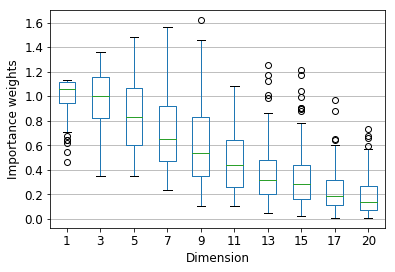

In [16]:
f, ax = plt.subplots()
ax.set_xlabel('Dimension')
ax.set_ylabel('Importance weights')
iws.boxplot(boxprops=boxprops)
ax.xaxis.grid(False)
plt.savefig('importance_weights_boxplot1.pdf', bbox_inches='tight')

In [6]:
# Compute importance weights for different dimensions
torch.manual_seed(42)
# Dimensions to use
n_repeats = 100
ds = np.linspace(100, 1000, 10).astype(np.int64) # np.logspace(0, 5, num=10).astype(int)
ds = np.append(np.array([10]), ds)
display(ds)
iws = pd.DataFrame()
iws_pseudo = pd.DataFrame()
for d in ds:
    iws_this_d = []
    iws_pseudo_this_d = []
    for n in range(n_repeats):
        # Noise for parameters
        n = 0.01 * torch.FloatTensor(int(d)).normal_(mean=0, std=1)
        # Current
        m1, s1 = get_gaussian_parameters(d, mean=1.1, sigma=0.90, noise=n)
        # Previous
        m2, s2 = get_gaussian_parameters(d, mean=1.0, sigma=1.0, noise=n)
        # Sample from previous
        sample = torch.FloatTensor(int(d)).normal_(mean=1.0, std=1.0)
        # Importance weight for acceptance into new distribution
        iw = compute_importance_weight(sample, m1, s1, m2, s2)
        iws_this_d.append(iw)
        iw_pseudo = compute_pseudo_importance_weight(sample, m1, s1, m2, s2)[0]
        iws_pseudo_this_d.append(iw_pseudo)
        
    iws[d] = iws_this_d
    iws_pseudo[d] = iws_pseudo_this_d
    print('d={d}'.format(d=d), end='\r')

array([  10,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

In [7]:
display(iws)
display(iws_pseudo)

,10,100,200,300,400,500,600,700,800,900,1000
0,0.517293,1.291180e-06,1.487461e-11,9.242978e-19,3.357167e-21,3.844018e-27,1.476259e-30,2.839043e-39,4.213589e-42,9.727422e-45,2.462107e-52
1,0.951026,7.506011e-05,2.640354e-11,4.380287e-19,6.963648e-20,2.222912e-23,9.842112e-32,2.045889e-35,5.136556e-46,1.749862e-53,4.933052e-52
2,0.136115,6.720307e-06,2.175191e-11,3.635532e-17,5.448640e-20,1.385942e-23,1.042857e-31,2.883232e-37,4.002964e-42,1.836625e-50,1.147973e-52
3,0.282077,4.424590e-06,7.315549e-11,1.518330e-16,5.087265e-23,2.079045e-28,2.240168e-34,4.208881e-36,7.341828e-42,3.804111e-51,9.948863e-55
4,0.547758,1.224166e-05,3.283394e-11,2.167633e-15,1.367463e-21,5.014539e-28,5.427828e-30,8.266210e-38,9.497154e-45,1.045738e-46,1.015920e-52
5,1.123288,1.517034e-05,6.182486e-12,7.448661e-19,4.400437e-24,4.637113e-27,1.727185e-33,2.688027e-35,2.271420e-41,1.060021e-44,1.274302e-58
6,0.262850,2.410438e-06,4.252501e-10,8.473108e-15,3.015421e-20,8.124361e-29,2.241519e-31,4.570661e-36,3.163326e-46,5.070313e-52,3.076561e-55
7,0.260305,1.392746e-05,1.132570e-12,7.866825e-17,5.334949e-22,1.482997e-24,5.433294e-33,2.737274e-39,4.627188e-44,6.782862e-47,3.130619e-52
8,0.164757,1.151075e-05,1.311006e-10,1.095795e-17,1.488947e-22,1.560127e-26,6.429355e-33,1.255632e-41,4.904191e-42,3.855427e-49,5.165467e-52
9,0.728838,1.049845e-04,3.443099e-11,1.228858e-17,2.219385e-19,2.399093e-28,6.524012e-35,4.401104e-34,8.264061e-48,6.891333e-46,1.138396e-50


,10,100,200,300,400,500,600,700,800,900,1000
0,0.999904,1.000018,1.000015,0.999990,0.999996,0.999996,0.999991,1.000006,1.000010,0.999998,0.999990
1,0.999930,1.000088,1.000044,1.000001,0.999974,0.999992,1.000007,1.000016,1.000011,0.999997,1.000015
2,1.000213,0.999993,1.000030,0.999966,1.000027,1.000004,0.999982,0.999989,0.999975,1.000025,0.999998
3,1.000065,1.000004,1.000045,1.000018,1.000009,0.999990,1.000011,1.000017,1.000002,1.000009,1.000006
4,0.999967,1.000067,0.999994,1.000015,1.000003,0.999987,0.999975,1.000008,1.000008,0.999978,1.000005
5,1.000090,0.999968,0.999989,0.999978,1.000034,1.000005,0.999983,0.999975,1.000034,1.000009,0.999995
6,0.999963,1.000046,1.000008,1.000007,0.999992,1.000000,0.999997,0.999995,1.000010,0.999997,1.000002
7,0.999838,1.000017,0.999987,1.000004,1.000029,1.000000,1.000016,0.999991,0.999978,1.000010,1.000002
8,1.000156,0.999937,1.000019,1.000026,0.999987,0.999994,1.000012,1.000005,0.999995,0.999986,1.000003
9,0.999927,0.999954,1.000041,1.000005,1.000005,1.000006,1.000016,1.000001,0.999999,1.000029,0.999990


TypeError: boxplot() got an unexpected keyword argument 'linewidth'

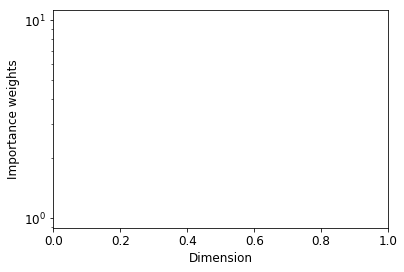

In [8]:
f, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('Dimension')
ax.set_ylabel('Importance weights')
iws.boxplot()
ax.xaxis.grid(False)
plt.savefig('importance_weights_boxplot2.pdf', bbox_inches='tight')

In [ ]:
# Dimensions to use
n_repeats = 100
ds = np.linspace(100, 10000, 10).astype(np.int64) # np.logspace(0, 5, num=10).astype(int)
ds = np.append(np.array([10]), ds)
display(ds)
iws_pseudo = pd.DataFrame()
for d in ds:
    iws_this_d = []
    iws_pseudo_this_d = []
    for n in range(n_repeats):
        # Noise for parameters
        n = 0.01 * torch.FloatTensor(int(d)).normal_(mean=0, std=1)
        # Current
        m1, s1 = get_gaussian_parameters(d, mean=1.1, sigma=0.9, noise=n)
        # Previous
        m2, s2 = get_gaussian_parameters(d, mean=1.0, sigma=1.0, noise=n)
        # Sample from previous
        sample = torch.FloatTensor(int(d)).normal_(mean=1.0, std=1.0)
        # Importance weight for acceptance into new distribution
        iw_pseudo = compute_pseudo_importance_weight(s1 * sample, m1, s1, m2, s2)[0]
        iws_pseudo_this_d.append(iw_pseudo)
        
    iws_pseudo[d] = iws_pseudo_this_d
    print('d={d}'.format(d=d), end='\r')

In [ ]:
f, ax = plt.subplots()
# ax.set_yscale('log')
ax.set_xlabel('Dimension')
ax.set_ylabel('Importance weights')
iws_pseudo.boxplot()
ax.xaxis.grid(False)
plt.savefig('importance_weights_boxplot3.pdf', bbox_inches='tight')

In [ ]:
df = pd.DataFrame([])

In [ ]:
df['asd'] = [4,2,3,1]


In [ ]:
df